In [1]:
import numpy as np
from imageio import imread
import glob
import matplotlib.pyplot as plt
from skimage.color import rgb2grey
import tensorflow as tf
%matplotlib inline

In [ ]:
#import dill
#SAVE
#dill.dump_session('notebook_env.db')

#LOAD
#dill.load_session('notebook_env.db')

## Functions

In [3]:
def load_ww():
    # Loads the MNIST dataset from png images
      
    # create list of image objects
    test_images = []
    test_labels = []    
     
    for image_path in sorted(glob.glob("WARWICK/Test/label*.png")):
        image = imread(image_path)
        test_labels.append(image)
    
    
    for image_path in sorted(glob.glob("WARWICK/Test/image*.png")):
        #image = rgb2grey(imread(image_path))
        image = imread(image_path)
        test_images.append(image) 
            
    # create list of image objects
    train_images = []
    train_labels = []    
    
    for image_path in sorted(glob.glob("WARWICK/Train/label*.png")):
        image = imread(image_path)
        train_labels.append(image)
    
    
    for image_path in sorted(glob.glob("WARWICK/Train/image*.png")):
        #image = rgb2grey(imread(image_path))
        image = imread(image_path)
        train_images.append(image)          
            
    #X_train= np.array(train_images,dtype='float32').reshape(-1,128,128,1)
    X_train= np.array(train_images,dtype='float32').reshape(-1,128,128,3)
    Y_train= np.array(train_labels,dtype='float32').reshape(-1,128,128,1)
    #X_test= np.array(test_images,dtype='float32').reshape(-1,128,128,1)
    X_test= np.array(test_images,dtype='float32').reshape(-1,128,128,3)
    Y_test= np.array(test_labels,dtype='float32').reshape(-1,128,128,1)
    
    #normalization
    Y_train /= 255.
    Y_test /= 255.
    """
    mean_train = np.mean(X_train)  # mean for data centering
    std_train = np.std(X_train)  # std for data normalization
    mean_test = np.mean(X_test)  # mean for data centering
    std_test = np.std(X_test)  # std for data normalization
    
    X_train -= mean_train
    X_train /= std_train
    X_test -= mean_test
    X_test /= std_test
    """
    X_train /= 255.0
    X_test /= 255.0
    
    return X_train, Y_train, X_test, Y_test



In [4]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

## Load Data

In [5]:
X_train,Y_train,X_test,Y_test=load_ww()

---
# Starting Model / Exercise 2.1
---

In [6]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, InputLayer, Activation
from keras.optimizers import Adam,Adagrad,RMSprop,SGD,Adadelta
from keras import backend as K

Using TensorFlow backend.


In [7]:
K.clear_session()

In [8]:
inputs = Input((128,128,3))
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=inputs, outputs=conv10)

In [10]:
model.compile(loss=dice_coef_loss, optimizer=Adam(), metrics=[dice_coef])
#model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

In [11]:
hist = model.fit(X_train, Y_train, epochs=15, batch_size=8,validation_data=[X_test,Y_test])

Train on 85 samples, validate on 60 samples
Epoch 1/15
85/85 [==============================] - 5s 64ms/step - loss: 0.1565 - dice_coef: 0.8435 - val_loss: 0.1561 - val_dice_coef: 0.8439
Epoch 2/15
85/85 [==============================] - 4s 43ms/step - loss: 0.1539 - dice_coef: 0.8461 - val_loss: 0.1557 - val_dice_coef: 0.8443
Epoch 3/15
85/85 [==============================] - 3s 39ms/step - loss: 0.1511 - dice_coef: 0.8489 - val_loss: 0.1568 - val_dice_coef: 0.8432
Epoch 4/15
85/85 [==============================] - 3s 40ms/step - loss: 0.1465 - dice_coef: 0.8535 - val_loss: 0.1543 - val_dice_coef: 0.8457
Epoch 5/15
85/85 [==============================] - 4s 44ms/step - loss: 0.1409 - dice_coef: 0.8591 - val_loss: 0.1481 - val_dice_coef: 0.8519
Epoch 6/15
85/85 [==============================] - 4s 43ms/step - loss: 0.1310 - dice_coef: 0.8690 - val_loss: 0.1408 - val_dice_coef: 0.8592
Epoch 7/15
85/85 [==============================] - 5s 54ms/step - loss: 0.1249 - dice_coef: 0.875

## Test Error

In [16]:
print('Accuracy on TEST data\n')
score = model.evaluate(X_test, Y_test) 
predictions = model.predict(X_test)
print('Dice ', score[1])

Accuracy on TEST data

60/60 [==============================] - 0s 6ms/step
Dice  0.875162128607432


In [19]:
test_dices=[]
for i in range(len(Y_test)):
    test_dices.append(K.sum(dice_coef(Y_test[i],predictions[i])))
    
#initialize
init = tf.global_variables_initializer()

#run the graph
with tf.Session() as sess:
    sess.run(init) #execute init_op
    #print
    test_dices=np.array(sess.run(test_dices))
    
test_dices/=128*128

In [20]:
print("Sørensen–Dice coefficients for Test data\n\n")
for i in range(len(test_dices)):
    print(i,test_dices[i])

Sørensen–Dice coefficients for Test data


0 0.77805877
1 0.93314445
2 0.89400005
3 0.91193974
4 0.8343102
5 0.8565439
6 0.86941296
7 0.91542536
8 0.8318643
9 0.79742575
10 0.86195636
11 0.90724254
12 0.9070482
13 0.80914384
14 0.8724076
15 0.8888892
16 0.88815254
17 0.7877654
18 0.8889457
19 0.84755677
20 0.76610434
21 0.9093723
22 0.9033775
23 0.8887583
24 0.82559884
25 0.88299406
26 0.86158085
27 0.8147263
28 0.922101
29 0.9233556
30 0.95620954
31 0.9050517
32 0.8527016
33 0.8850248
34 0.9181618
35 0.8701904
36 0.8717952
37 0.9100893
38 0.82434916
39 0.88849854
40 0.82685536
41 0.8658371
42 0.89801836
43 0.9154235
44 0.79296327
45 0.8600452
46 0.9089329
47 0.89306176
48 0.8795502
49 0.9042558
50 0.88116086
51 0.93175703
52 0.8290794
53 0.81855464
54 0.86449873
55 0.89992464
56 0.93363416
57 0.8832332
58 0.9188442
59 0.93798757


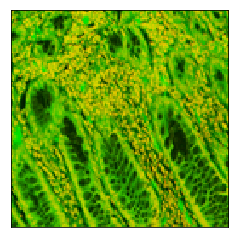

In [43]:
i=20
plt.imshow(X_test[i])
plt.xticks([])
plt.yticks([])
plt.savefig('bad_example_image_21.png',dpi=300)

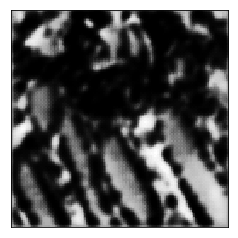

In [44]:
plt.imshow(predictions[i].reshape(128,128),cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.savefig('bad_example_label_21.png',dpi=300)

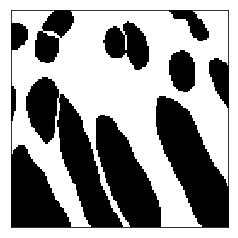

In [45]:
plt.imshow(Y_test[i].reshape(128,128),cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.savefig('bad_example_true_21.png',dpi=300)

---
## Generating Multiplot
---

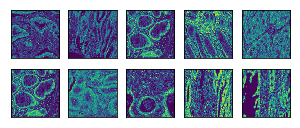

In [38]:
#converting
numb=10
test_size = len(Y_test)
test_data = X_test #.reshape((10000, 28, 28, 1))
pred_data = predictions

# Extract 100 random test images
batch_test_ind = np.random.choice(test_size,numb)

# Do the plot of the images
num_rows = 2
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, i_im in enumerate(batch_test_ind, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[i_im,:,:,0])     
                  
plt.savefig("test_figs_21.png",dpi=300)

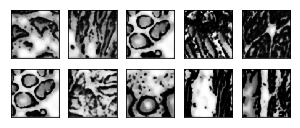

In [39]:
plt.figure(figsize=(num_cols, num_rows))
for i, i_im in enumerate(batch_test_ind, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(pred_data[i_im,:,:,0], cmap=plt.cm.binary)  

plt.savefig("label_predict_21.png",dpi=300)

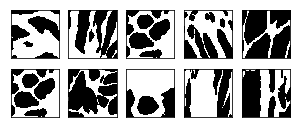

In [56]:
plt.figure(figsize=(num_cols, num_rows))
for i, i_im in enumerate(batch_test_ind, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i_im,:,:,0], cmap=plt.cm.binary)  

plt.savefig("label_true_21.png",dpi=300)

---

---
# Model 1 + Regularizer
---

In [51]:
from keras.regularizers import l2

In [84]:
K.clear_session()

In [85]:
inputs = Input((128,128,3))
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid',kernel_regularizer=l2())(conv9)

model_1 = Model(inputs=inputs, outputs=conv10)

In [86]:
model_1.compile(loss=dice_coef_loss, optimizer=Adam(), metrics=[dice_coef])

In [87]:
hist_1 = model_1.fit(X_train, Y_train, epochs=30, batch_size=8,validation_data=[X_test,Y_test])

Train on 85 samples, validate on 60 samples
Epoch 1/30
85/85 [==============================] - 6s 70ms/step - loss: 0.1640 - dice_coef: 0.8449 - val_loss: 0.1633 - val_dice_coef: 0.8452
Epoch 2/30
85/85 [==============================] - 4s 46ms/step - loss: 0.1624 - dice_coef: 0.8460 - val_loss: 0.1604 - val_dice_coef: 0.8477
Epoch 3/30
85/85 [==============================] - 4s 44ms/step - loss: 0.1599 - dice_coef: 0.8480 - val_loss: 0.1571 - val_dice_coef: 0.8506
Epoch 4/30
85/85 [==============================] - 4s 42ms/step - loss: 0.1561 - dice_coef: 0.8514 - val_loss: 0.1553 - val_dice_coef: 0.8521
Epoch 5/30
85/85 [==============================] - 4s 44ms/step - loss: 0.1508 - dice_coef: 0.8565 - val_loss: 0.1573 - val_dice_coef: 0.8497
Epoch 6/30
85/85 [==============================] - 4s 44ms/step - loss: 0.1457 - dice_coef: 0.8613 - val_loss: 0.1592 - val_dice_coef: 0.8475
Epoch 7/30
85/85 [==============================] - 4s 47ms/step - loss: 0.1434 - dice_coef: 0.863

## Test Error

In [88]:
print('Accuracy on TEST data\n')
score_1 = model_1.evaluate(X_test, Y_test) 
predictions_1 = model_1.predict(X_test)
print('Dice ', score_1[1])

Accuracy on TEST data

60/60 [==============================] - 1s 9ms/step
Dice  0.9135012865066529


---
## Generating Multiplot
---

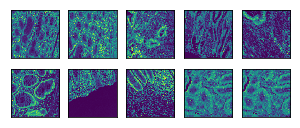

In [172]:
#converting
numb=10
test_size = len(Y_test)
test_data = X_test #.reshape((10000, 28, 28, 1))
pred_data = predictions_1

# Extract 100 random test images
batch_test_ind = np.random.choice(test_size,numb)

# Do the plot of the images
num_rows = 2
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, i_im in enumerate(batch_test_ind, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[i_im,:,:,0])     
                  
plt.savefig("test_figs_22-1.png",dpi=300)

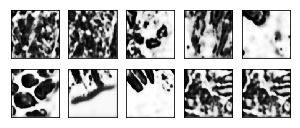

In [173]:
plt.figure(figsize=(num_cols, num_rows))
for i, i_im in enumerate(batch_test_ind, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(pred_data[i_im,:,:,0], cmap=plt.cm.binary)  

plt.savefig("label_predict_22-1.png",dpi=300)

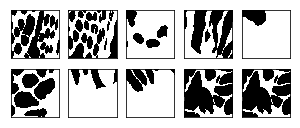

In [174]:
plt.figure(figsize=(num_cols, num_rows))
for i, i_im in enumerate(batch_test_ind, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i_im,:,:,0], cmap=plt.cm.binary)  

plt.savefig("label_true_22-1.png",dpi=300)

---
# Model 2 + Data Augmentation
---

In [128]:
from keras.preprocessing.image import ImageDataGenerator

In [141]:
from sklearn.model_selection import train_test_split

In [144]:
image,image_val,mask,mask_val = train_test_split(X_train,Y_train,test_size=0.2,random_state=1)

In [158]:
image_gen=ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
mask_gen=ImageDataGenerator(horizontal_flip=True,vertical_flip=True)

In [159]:
image_generator=image_gen.flow(image,seed=1,batch_size=8)
mask_generator=mask_gen.flow(mask,seed=1,batch_size=8)
train_generator = zip(image_generator, mask_generator)

In [160]:
image_generator_val=image_gen.flow(image_val,seed=1,batch_size=8)
mask_generator_val=mask_gen.flow(mask_val,seed=1,batch_size=8)
test_generator = zip(image_generator_val, mask_generator_val)


In [178]:
K.clear_session()

In [179]:
inputs = Input((128,128,3))
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model_2 = Model(inputs=inputs, outputs=conv10)

In [180]:
model_2.compile(loss=dice_coef_loss, optimizer=Adam(), metrics=[dice_coef])

In [181]:
hist_2 = model_2.fit_generator(train_generator,steps_per_epoch=30,epochs=30,validation_data=test_generator,validation_steps=10)

Epoch 1/30
30/30 [==============================] - 14s 472ms/step - loss: 0.1519 - dice_coef: 0.8481 - val_loss: 0.1515 - val_dice_coef: 0.8485
Epoch 2/30
30/30 [==============================] - 10s 338ms/step - loss: 0.1456 - dice_coef: 0.8544 - val_loss: 0.1414 - val_dice_coef: 0.8586
Epoch 3/30
30/30 [==============================] - 12s 389ms/step - loss: 0.1333 - dice_coef: 0.8667 - val_loss: 0.1339 - val_dice_coef: 0.8661
Epoch 4/30
30/30 [==============================] - 14s 469ms/step - loss: 0.1217 - dice_coef: 0.8783 - val_loss: 0.1178 - val_dice_coef: 0.8822
Epoch 5/30
30/30 [==============================] - 11s 383ms/step - loss: 0.1076 - dice_coef: 0.8924 - val_loss: 0.1227 - val_dice_coef: 0.8773
Epoch 6/30
30/30 [==============================] - 12s 396ms/step - loss: 0.0985 - dice_coef: 0.9016 - val_loss: 0.0932 - val_dice_coef: 0.9068
Epoch 7/30
30/30 [==============================] - 11s 377ms/step - loss: 0.0907 - dice_coef: 0.9094 - val_loss: 0.0901 - val_dic

## Test Error

In [182]:
print('Accuracy on TEST data\n')
score_2 = model_2.evaluate(X_test, Y_test) 
predictions_2 = model_2.predict(X_test)
print('Dice ', score_2[1])

Accuracy on TEST data

60/60 [==============================] - 0s 7ms/step
Dice  0.9350269993146261


---
## Generating Multiplot
---

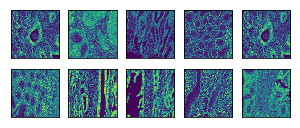

In [183]:
#converting
numb=10
test_size = len(Y_test)
test_data = X_test #.reshape((10000, 28, 28, 1))
pred_data = predictions_2

# Extract 100 random test images
batch_test_ind = np.random.choice(test_size,numb)

# Do the plot of the images
num_rows = 2
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, i_im in enumerate(batch_test_ind, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[i_im,:,:,0])     
                  
plt.savefig("test_figs_22-2.png",dpi=300)

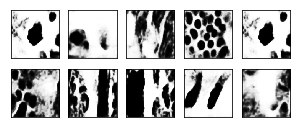

In [184]:
plt.figure(figsize=(num_cols, num_rows))
for i, i_im in enumerate(batch_test_ind, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(pred_data[i_im,:,:,0], cmap=plt.cm.binary)  

plt.savefig("label_predict_22-2.png",dpi=300)

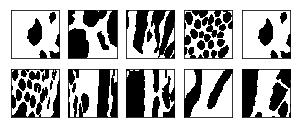

In [185]:
plt.figure(figsize=(num_cols, num_rows))
for i, i_im in enumerate(batch_test_ind, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i_im,:,:,0], cmap=plt.cm.binary)  

plt.savefig("label_true_22-2.png",dpi=300)

---
# Model 3 + Regularizer and Data Augmentation
---

In [211]:
K.clear_session()

In [212]:
inputs = Input((128,128,3))
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid',kernel_regularizer=l2(l=0.05))(conv9)

model_3 = Model(inputs=inputs, outputs=conv10)

In [213]:
model_3.compile(loss=dice_coef_loss, optimizer=Adam(lr=1e-3), metrics=[dice_coef])

In [214]:
hist_3 = model_3.fit_generator(train_generator,steps_per_epoch=30,epochs=30,validation_data=test_generator,validation_steps=10)

Epoch 1/30
30/30 [==============================] - 12s 405ms/step - loss: 0.2209 - dice_coef: 0.8454 - val_loss: 0.2150 - val_dice_coef: 0.8475
Epoch 2/30
30/30 [==============================] - 9s 288ms/step - loss: 0.2066 - dice_coef: 0.8526 - val_loss: 0.1961 - val_dice_coef: 0.8597
Epoch 3/30
30/30 [==============================] - 8s 267ms/step - loss: 0.1901 - dice_coef: 0.8627 - val_loss: 0.1951 - val_dice_coef: 0.8546
Epoch 4/30
30/30 [==============================] - 9s 301ms/step - loss: 0.1790 - dice_coef: 0.8682 - val_loss: 0.1742 - val_dice_coef: 0.8704
Epoch 5/30
30/30 [==============================] - 10s 324ms/step - loss: 0.1553 - dice_coef: 0.8872 - val_loss: 0.1579 - val_dice_coef: 0.8822
Epoch 6/30
30/30 [==============================] - 9s 309ms/step - loss: 0.1415 - dice_coef: 0.8963 - val_loss: 0.1448 - val_dice_coef: 0.8907
Epoch 7/30
30/30 [==============================] - 9s 309ms/step - loss: 0.1358 - dice_coef: 0.8977 - val_loss: 0.1290 - val_dice_coe

## Test Error

In [215]:
print('Accuracy on TEST data\n')
score_3 = model_3.evaluate(X_test, Y_test) 
predictions_3 = model_3.predict(X_test)
print('Dice ', score_3[1])

Accuracy on TEST data

60/60 [==============================] - 0s 7ms/step
Dice  0.9361078461011251


---
## Generating Multiplot
---

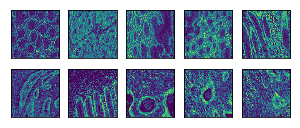

In [219]:
#converting
numb=10
test_size = len(Y_test)
test_data = X_test #.reshape((10000, 28, 28, 1))
pred_data = predictions_3

# Extract 100 random test images
batch_test_ind = np.random.choice(test_size,numb)

# Do the plot of the images
num_rows = 2
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, i_im in enumerate(batch_test_ind, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[i_im,:,:,0])     
                  
plt.savefig("test_figs_22-3.png",dpi=300)

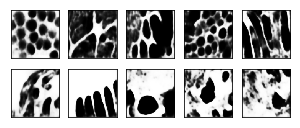

In [220]:
plt.figure(figsize=(num_cols, num_rows))
for i, i_im in enumerate(batch_test_ind, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(pred_data[i_im,:,:,0], cmap=plt.cm.binary)  

plt.savefig("label_predict_22-3.png",dpi=300)

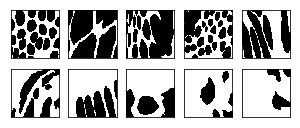

In [221]:
plt.figure(figsize=(num_cols, num_rows))
for i, i_im in enumerate(batch_test_ind, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i_im,:,:,0], cmap=plt.cm.binary)  

plt.savefig("label_true_22-3.png",dpi=300)